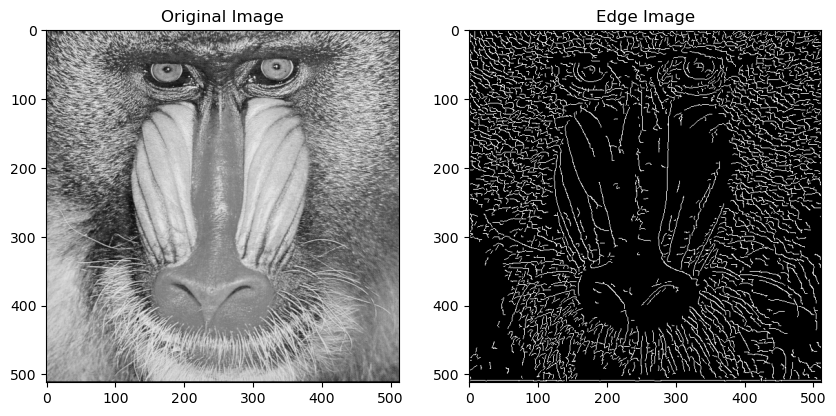

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_filter(img, sigma):
    kernel_size = int(2*np.ceil(2*sigma)+1)
    gaussian_kernel = np.zeros((kernel_size, kernel_size))
    m = kernel_size // 2
    n = kernel_size // 2
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = np.exp(-(x**2 + y**2) / (2*sigma**2))
            x2 = 2 * np.pi * sigma**2
            gaussian_kernel[x+m, y+n] = x1 / x2
    return cv2.filter2D(img, -1, gaussian_kernel)

def sobel_filter(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = cv2.filter2D(img, -1, Kx)
    Iy = cv2.filter2D(img, -1, Ky)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G, theta

def non_maximum_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]
                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

def threshold(img, low, high):
    high_threshold = img.max() * high
    low_threshold = high_threshold * low
    res = np.zeros_like(img)
    strong_i, strong_j = np.where(img >= high_threshold)
    zeros_i, zeros_j = np.where(img < low_threshold)
    weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))
    res[strong_i, strong_j] = 255
    res[weak_i, weak_j] = 75
    return res

def edge_tracking(img):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == 75):
                if (255 in [img[i+1, j-1], img[i+1, j], img[i+1, j+1], img[i, j-1], img[i, j+1], img[i-1, j-1], img[i-1, j], img[i-1, j+1]]):
                    img[i, j] = 255
                else:
                    img[i, j] = 0
    return img

def canny_edge_detection(img, sigma, low_threshold, high_threshold):
    img_blur = gaussian_filter(img, sigma)
    G, theta = sobel_filter(img_blur)
    img_nms = non_maximum_suppression(G, theta)
    img_thresh = threshold(img_nms, low_threshold, high_threshold)
    img_edge = edge_tracking(img_thresh)
    return img_edge

# 이미지 불러오기
img = cv2.imread('./image/babbon.bmp', cv2.IMREAD_GRAYSCALE)

# Canny 에지 검출 적용
edges = canny_edge_detection(img, sigma=2, low_threshold=0.05, high_threshold=0.15)

# 결과 출력
plt.figure(figsize=(10, 7))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge Image')
plt.show()
